DANN based on:

https://github.com/ataakbari/DANN

https://github.com/pumpikano/tf-dann/blob/master/MNIST-DANN.ipynb

MNIST

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
from __future__ import print_function
import keras
import json
from keras.models import model_from_json
import tensorflow as tf
from keras.engine import Layer
import pickle as pk
import numpy as np
import keras.layers as kl
import keras.backend as K
K.set_image_data_format('channels_first')
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from keras.utils.vis_utils import plot_model
from keras.regularizers import l2

Using TensorFlow backend.


In [0]:
#import data

# pristine images
file_x_data = "/content/drive/My Drive/DeepMergeFiles/SB00_augmented.npy" # x data (images)
file_y_data = "/content/drive/My Drive/DeepMergeFiles/SB00_augmented_y.npy" # y data (labels) 

# noisy images
file_x_data_noisy = "/content/drive/My Drive/DeepMergeFiles/SB25_augmented.npy" 
file_y_data_noisy = "/content/drive/My Drive/DeepMergeFiles/SB25_augmented_y.npy"  

In [0]:
def reverse_gradient(X, hp_lambda):
    '''Flips the sign of the incoming gradient during training.'''
    try:
        reverse_gradient.num_calls += 1
    except AttributeError:
        reverse_gradient.num_calls = 1

    grad_name = "GradientReversal%d" % reverse_gradient.num_calls

    @tf.RegisterGradient(grad_name)
    def _flip_gradients(op, grad):
        return [tf.negative(grad) * hp_lambda]

    g = K.get_session().graph
    with g.gradient_override_map({'Identity': grad_name}):
        y = tf.identity(X)

    return y


class GradientReversal(Layer):
    '''Flip the sign of gradient during training.'''
    def __init__(self, hp_lambda=1.0, **kwargs):
        super(GradientReversal, self).__init__(**kwargs)
        self.supports_masking = False
        self.hp_lambda = hp_lambda

    def build(self, input_shape):
        self.trainable_weights = []

    def call(self, x, mask=None):
        return reverse_gradient(x, self.hp_lambda)

    def get_output_shape_for(self, input_shape):
        return input_shape

    def get_config(self):
        config = {}
        base_config = super(GradientReversal, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [0]:
class DANN(object):
	def __init__(self, width=28, height=28, channels=3, classes=1, features=1, batch_size=1, grl='auto', summary=False, model_plot=False):
		## Set Defualts
		self.learning_phase = K.variable(1)
		self.domain_invariant_features = None
		self.width, self.height, self.channels = width, height, channels
		self.input_shape = (channels, width, height)
		self.classes = classes
		self.features = features
		self.batch_size = batch_size
		self.grl = 'auto'
		# Set reversal gradient value.
		if grl is 'auto':
			self.grl_rate = 1.0
		else:
			self.grl_rate = grl
		self.summary = summary
		self.model_plot = model_plot

		# Build the model
		self.model = self._build()
		
		# Print and Save the model summary if requested.
		if self.summary:
			self.model.summary()
		if self.model_plot:
			plot_model(self.model, to_file='/content/drive/My Drive/Colab Notebooks/DANN/model_plot_mergers.png', show_shapes=True, show_layer_names=True)

	def feature_extractor(self, inp):
		''' 
		This function defines the structure of the feature extractor part.
		'''
		out = kl.Conv2D(filters=8, kernel_size=(5, 5), padding="same", strides=(1, 1), activation="relu")(inp)
		out = kl.BatchNormalization()(out)
		out = kl.MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid')(out)
		out = kl.Dropout(0.5)(out)

		out = kl.Conv2D(filters=16, kernel_size=(3, 3), padding="same", strides=(1, 1), activation="relu")(out)
		out = kl.BatchNormalization()(out)
		out = kl.MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid')(out)
		out = kl.Dropout(0.5)(out)
	
		out = kl.Conv2D(filters=32, kernel_size=(3, 3), padding="same", strides=(1, 1), activation="relu")(out)
		out = kl.BatchNormalization()(out)
		out = kl.MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid')(out)
		out = kl.Dropout(0.5)(out)

		out = kl.Flatten()(out)

		feature_output = kl.Dense(self.features, activation="relu")(out)
		self.domain_invariant_features = feature_output
		return feature_output

	def classifier(self, inp):
		''' 
		This function defines the structure of the classifier part.
		'''
		out = kl.Dense(64, activation='relu')(inp)#kernel_regularizer=l2(0.0001)
		out = kl.Dense(32, activation='relu')(out)
	  #try out two classes and softmax in the last layer, and also relu in the two above
		classifier_output = kl.Dense(self.classes, activation="sigmoid", name="classifier_output")(out)
		return classifier_output

	def discriminator(self, inp):
		''' 
		This function defines the structure of the discriminator part.
		'''
		out = kl.Dense(32, activation="relu")(inp)
		out = kl.Dropout(0.5)(out)
		discriminator_output = kl.Dense(2, activation="sigmoid", name="discriminator_output")(out)
		return discriminator_output

	def _build(self):
		'''
		This function builds the network based on the Feature Extractor, Classifier and Discriminator parts.
		'''
		inp = kl.Input(shape=self.input_shape, name="main_input")
		feature_output = self.feature_extractor(inp)
		self.grl_layer = GradientReversal(1.0)
		feature_output_grl = self.grl_layer(feature_output)
		labeled_feature_output = kl.Lambda(lambda x, batch=self.batch_size: K.switch(K.learning_phase(), K.concatenate([x[:int(batch//2)], x[:int(batch//2)]], axis=0), x), output_shape=lambda x: x[0:])(feature_output)

		#inp = kl.Input(shape=self.input_shape, name="main_input")
		#feature_output = self.feature_extractor(inp)
		#self.grl_layer = GradientReversal(1.0)
		#feature_output_grl = self.grl_layer(feature_output)
		#labeled_feature_output = kl.Lambda(lambda x, batch=self.batch_size: K.switch(K.learning_phase(), K.concatenate([x[:int(batch//2)], x[:int(batch//2)]], axis=0), x), output_shape=lambda x: x[0:])(feature_output_grl)



		classifier_output = self.classifier(labeled_feature_output)
		#discriminator_output = self.discriminator(feature_output)
		discriminator_output = self.discriminator(feature_output_grl)
		model = keras.models.Model(inputs=inp, outputs=[discriminator_output, classifier_output])
		return model

	def batch_generator(self, trainX, trainY=None, batch_size=1, shuffle=True):
		'''
		This function generates batches for the training purposes.
		'''
		if shuffle:
			index = np.random.randint(0, len(trainX) - batch_size)
		else:
			index = np.arange(0, len(trainX), batch_size)
		while trainX.shape[0] > index + batch_size:
			batch_images = trainX[index : index + batch_size]
			batch_images = batch_images.reshape(batch_size, self.channels, self.width, self.height)
			if trainY is not None:
				batch_labels = trainY[index : index + batch_size]
				yield batch_images, batch_labels
			else:
				yield batch_images
			index += batch_size

	def compile(self, optimizer):
		'''
		This function compiles the model based on the given optimization method and its parameters.
		'''
		self.model.compile(optimizer=optimizer, loss={'classifier_output': 'binary_crossentropy', 'discriminator_output': 'binary_crossentropy'}, loss_weights={'classifier_output': 0.5, 'discriminator_output': 1.0})

	def train(self, trainX, trainDX, trainY=None, epochs=1, batch_size=1, verbose=True, save_model=None):
		'''
		This function trains the model using the input and target data, and saves the model if specified.
		'''
		metrics_list=[]

		for cnt in range(epochs):

		# Prepare batch data for the model training.
			Labeled = self.batch_generator(trainX, trainY, batch_size=batch_size // 2)
			UNLabeled = self.batch_generator(trainDX, batch_size=batch_size // 2)
			
			# Settings for learning rate.
			p = np.float(cnt) / epochs
			lr = 0.01 / (1. + 10 * p)**0.75

			# Settings for reverse gradient magnitude (if it's set to be automatically calculated, otherwise set by user.)
			if self.grl is 'auto':
				self.grl_layer.l = 2. / (1. + np.exp(-10. * p)) - 1

			# Re-compile model to adopt new learning rate and gradient reversal value.
			self.compile(keras.optimizers.SGD(lr))

			# Loop over each batch and train the model.
			for batchX, batchY in Labeled:
				# Get the batch for unlabeled data. If the batches are finished, regenerate the batches agian.
				try:
					batchDX = next(UNLabeled)
				except:
					UNLabeled = self.batch_generator(trainDX, batch_size=batch_size // 2)
				# Combine the labeled and unlabeled images along with the discriminative results.
				combined_batchX = np.concatenate((batchX, batchDX))
				batch2Y = np.concatenate((batchY, batchY))
				combined_batchY = np.concatenate((np.tile([0, 1], [batchX.shape[0], 1]), np.tile([1, 0], [batchDX.shape[0], 1])))
				# Train the model
				metrics = self.model.train_on_batch({'main_input': combined_batchX}, {'classifier_output': batch2Y, 'discriminator_output':combined_batchY})

			# Print the losses if asked for.
			if verbose:
				print("Epoch {}/{}\n\t[Generator_loss: {:.4}, Discriminator_loss: {:.4}, Classifier_loss: {:.4}]".format(cnt+1, epochs, metrics[0], metrics[1], metrics[2]))
				metrics_list.append(metrics[:3])
		# Save the model if asked for.
		if save_model is not None and isinstance(save_model, str):
			save_history = ''.join((save_model[:-3], "_history.npy"))
			np.save(save_history, metrics_list)
			print("Saved history to disk")
			self.model.save(save_model)
			print("Saved model to disk")
	  #if save_model[-3:] is not ".h5":
				#save_model = ''.join((save_model, ".json"))
			#with open(save_history, 'w') as f:
			#	json.dump(str(metrics_list), f)
		elif save_model is not None and not isinstance(save_model, str):
			raise TypeError("The input must be a filename for model settings in string format.")



	def evaluate(self, testX, testY=None, weight_loc=None, save_pred=None, verbose=False):
		'''
		This function evaluates the model, and generates the predicted classes.
		'''
		if weight_loc is not None:
			self.compile(keras.optimizers.SGD())
			self.model.load_weights(weight_loc)
		_, yhat_class = self.model.predict(testX, verbose=verbose)
		if save_pred is not None:
			np.save(save_pred, yhat_class)
		if testY is not None and len(testY) == 2:
			acc = self.model.evaluate(testX, testY, verbose=verbose)
			if verbose:
				print("The classifier and discriminator metrics for evaluation are [{}, {}]".format(acc[0], acc[1]))
		elif testY is not None and len(testY) == 1:
			acc = self.model.evaluate(testX, [np.ones((testY.shape[0], 2)), testY], verbose=verbose)
			if verbose:
				print("The classifier metric for evaluation is {}".format(acc[1]))

In [0]:
# load data, all filters
x_data = np.load(file_x_data)
y_data = np.load(file_y_data)

# load data, all filters, noisy
x_data_noisy = np.load(file_x_data_noisy)
y_data_noisy = np.load(file_y_data_noisy)

In [0]:
# Divide train and test sets (the only limitation of this model is to assign even number as batch_sizes and the size of data should yield 0 remainder.)
trainX, testX = x_data[:12340], x_data[12340:15420]
trainY = keras.utils.to_categorical(y_data, num_classes=2)
trainY, testY = trainY[:12340], trainY[12340:15420]
#batch size should be 20

In [0]:
# make noisy images to be out of domain unlabeled data
trainDX = x_data_noisy[:12340]
testDX = x_data_noisy[12340:15420]

In [0]:
#should I rescale to (-1,1)?
## Rescale -1 to 1
#trainX = (trainX.astype(np.float32) - 127.5) / 127.5
#trainDX = (trainDX.astype(np.float32) - 127.5) / 127.5
#testX = (testX.astype(np.float32) - 127.5) / 127.5
#testDX = (testDX.astype(np.float32) - 127.5) / 127.5

In [9]:
# Initiate the model
#feature number??
dann = DANN(summary=True, width=75, height=75, channels=2, classes=2, features=64, batch_size=20, model_plot=True)
# Train the model
dann.train(trainX, trainDX, trainY, epochs=5, batch_size=20, save_model="/content/drive/My Drive/Colab Notebooks/DANN/merger_model.h5")
# Evaluate for pristine
dann.evaluate(testX, testY, save_pred="/content/drive/My Drive/Colab Notebooks/DANN/pristine_test.npy", verbose=True)
# Evaluate for noisy
dann.evaluate(testDX, save_pred="/content/drive/My Drive/Colab Notebooks/DANN/noisy_test.npy", verbose=True)













Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 2, 75, 75)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 8, 75, 75)    408         main_input[0][0]                 
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 8, 75, 75)    300         conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 8, 37, 37)    0          

In [10]:
#Loading model
model = load_model('/content/drive/My Drive/Colab Notebooks/DANN/merger_model.h5', custom_objects={'GradientReversal': GradientReversal})

NameError: ignored

In [11]:
#Load history
history= np.load("/content/drive/My Drive/Colab Notebooks/DANN/merger_model_history.npy")
print(history)

[[6.6482735e-01 6.6218388e-01 5.2869851e-03]
 [6.8635428e-01 6.8615913e-01 3.9035029e-04]
 [7.0325446e-01 7.0298541e-01 5.3810747e-04]
 [6.9552016e-01 6.9514716e-01 7.4605376e-04]
 [6.9960314e-01 6.9810498e-01 2.9963348e-03]]


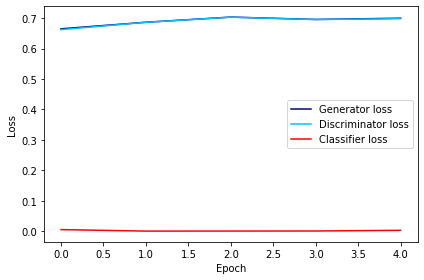

In [12]:
#plotting from history
#LOSS
import matplotlib.pyplot as plt
%matplotlib inline

gen_loss=history[:,0].tolist()
disc_loss=history[:,1].tolist()
class_loss=history[:,2].tolist()

epochs = list(range(len(history)))
figsize=(6,4)
fig, axis1 = plt.subplots(figsize=figsize)
plot_gen = axis1.plot(epochs, gen_loss, 'navy', label='Generator loss')
plot_disc = axis1.plot(epochs, disc_loss, 'deepskyblue', label="Discriminator loss")
plot_class = axis1.plot(epochs, class_loss, 'red', label="Classifier loss")

plots = plot_gen + plot_disc + plot_class
labs = [l.get_label() for l in plots]
axis1.set_xlabel('Epoch')
axis1.set_ylabel('Loss')
plt.tight_layout()
axis1.legend(loc='center right')

In [0]:
#import codecs
#import os
##loading history
#path = "/content/drive/My Drive/Colab Notebooks/DANN/merger_model_history.json"
#if os.path.exists(path): # reload history if it exists
#        with codecs.open(path, 'r', encoding='utf-8') as f:
#             n = json.loads(f.read())

#print(n)
#n_num=np.fromstring(n[2:-3], dtype=float, sep=',')
#print(n_num)

In [0]:
accc=np.load("/content/drive/My Drive/Colab Notebooks/DANN/noisy_test.npy")

In [14]:
accc[:10]

array([[0.96875525, 0.03279904],
       [0.9679078 , 0.03497142],
       [0.97289133, 0.02983338],
       [0.9661162 , 0.0361833 ],
       [0.9660364 , 0.03569391],
       [0.96933067, 0.03440261],
       [0.9739928 , 0.02804968],
       [0.96871316, 0.03380802],
       [0.967237  , 0.03484663],
       [0.96915036, 0.03356349]], dtype=float32)

In [0]:
acccc=np.load("/content/drive/My Drive/Colab Notebooks/DANN/pristine_test.npy")

In [0]:
acccc[:10]

array([[0.71107924, 0.23477381],
       [0.7114259 , 0.23465127],
       [0.71094656, 0.23480982],
       [0.7112052 , 0.23478448],
       [0.710945  , 0.23503843],
       [0.7112824 , 0.23488715],
       [0.7116258 , 0.23449972],
       [0.71158445, 0.23443541],
       [0.71151435, 0.23449436],
       [0.71136546, 0.2345699 ]], dtype=float32)